# MOVi Dataset Explorer 🎬

## 研究背景と目的

### なぜMOVi-Aデータセットか

物体中心表現学習（Object-centric Representation Learning）において、 **光沢のある物体（金属など）** は特に難しい問題とされている。

**問題点**:
- 光沢（specular highlight）は物体の固有の特徴ではなく、**視点・光源・カメラの相対位置**によって変化する
- 静止画では「白い斑点」が物体の模様なのか光沢なのか区別しにくい
- Slot Attentionなどの手法は、この光沢を別オブジェクトとして誤認識することがある

**仮説**: 
> 動画（時系列情報）を活用すれば、「光沢は動くが物体形状は一定」という性質から、より正確な物体分離が可能である

### MOVi-Aの特徴
- **材質ラベル付き**: `metal`（光沢あり）と `rubber`（つや消し）を明示的に区別
- **24フレームの動画**: カメラが動くので光沢パターンが変化
- **セグメンテーションマスク**: Ground truth として物体分離の正解を保持
- **シンプルな形状**: cube, cylinder, sphere のみ（形状バイアスを排除）

### なぜTensorFlowを使うのか（データ読み込みのみ）

MOVi-Aは**Google Kubricプロジェクト**が提供しており、公式配布形式が**TFRecord（TensorFlow Datasets）のみ**である。
- GCS上の `gs://kubric-public/tfds` から直接読み込む場合、`tensorflow-datasets` が必須
- ただし、読み込み後は即座に**PyTorchテンソルに変換**して保存するため、学習時にはTensorFlow不要
- 代替案として、TFRecordをローカルにダウンロードしてPyTorch用に変換するスクリプトも存在する（[kubric-public](https://github.com/google-research/kubric)参照）

**参考**: https://github.com/google-research/kubric/tree/main/challenges/movi

In [33]:
# 基本ライブラリ（TensorFlowなしで動作）
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import torch
import os

# 保存済みデータのパス
DATA_DIR = "../data/movi_a_subset"

# ラベルマッピング
SHAPE_LABELS = ["cube", "cylinder", "sphere"]
SIZE_LABELS = ["small", "large"]
COLOR_LABELS = ["blue", "brown", "cyan", "gray", "green", "purple", "red", "yellow"]
MATERIAL_LABELS = ["metal", "rubber"]
METAL_IDX = 0
RUBBER_IDX = 1

print(f"PyTorch version: {torch.__version__}")
print(f"Saved data directory: {os.path.abspath(DATA_DIR)}")
print(f"Available files: {os.listdir(DATA_DIR) if os.path.exists(DATA_DIR) else 'Not found'}")

PyTorch version: 2.10.0+cu128
Saved data directory: /home/menserve/Object-centric-representation/data/movi_a_subset
Available files: ['mixed_039.pt', 'mixed_006.pt', 'mixed_029.pt', 'metal_001.pt', 'metal_017.pt', 'metal_014.pt', 'mixed_037.pt', 'metal_005.pt', 'metal_019.pt', 'mixed_032.pt', 'metal_007.pt', 'mixed_023.pt', 'metal_004.pt', 'mixed_003.pt', 'mixed_016.pt', 'mixed_007.pt', 'metal_000.pt', 'mixed_018.pt', 'mixed_036.pt', 'mixed_004.pt', 'metal_009.pt', 'mixed_026.pt', 'metal_012.pt', 'mixed_005.pt', 'mixed_009.pt', 'metal_016.pt', 'mixed_013.pt', 'mixed_014.pt', 'metal_003.pt', 'mixed_019.pt', 'mixed_015.pt', 'mixed_001.pt', 'metal_002.pt', 'mixed_024.pt', 'mixed_035.pt', 'mixed_017.pt', 'metal_018.pt', 'metal_006.pt', 'mixed_038.pt', 'metal_011.pt', 'mixed_008.pt', 'mixed_033.pt', 'metal_010.pt', 'mixed_002.pt', 'mixed_031.pt', 'metal_008.pt', 'mixed_020.pt', 'metal_013.pt', 'mixed_011.pt', 'mixed_034.pt', 'mixed_000.pt', 'mixed_012.pt', 'mixed_022.pt', 'mixed_028.pt', 'm

## 1. 保存済みデータの読み込み

以前のセッションで MOVi-A から変換・保存した `.pt` ファイルを読み込む。
GCSからの再ダウンロードは不要である。

In [34]:
# 保存済み.ptファイルを読み込む
def load_saved_samples(data_dir):
    """保存済みのPyTorchサンプルを読み込む"""
    samples = {'metal': [], 'mixed': []}
    
    for fname in sorted(os.listdir(data_dir)):
        if fname.endswith('.pt'):
            path = os.path.join(data_dir, fname)
            sample = torch.load(path, weights_only=False)
            if fname.startswith('metal_'):
                samples['metal'].append(sample)
            elif fname.startswith('mixed_'):
                samples['mixed'].append(sample)
    
    print(f"Loaded {len(samples['metal'])} metal-only samples")
    print(f"Loaded {len(samples['mixed'])} mixed samples")
    return samples

samples = load_saved_samples(DATA_DIR)

# 最初のサンプルを確認
sample = samples['metal'][0] if samples['metal'] else samples['mixed'][0]
print(f"\nSample keys: {sample.keys()}")
print(f"Video shape: {sample['video'].shape}")
print(f"Materials: {sample['materials']}")

Loaded 20 metal-only samples
Loaded 40 mixed samples

Sample keys: dict_keys(['video', 'segmentation', 'materials', 'shapes', 'colors', 'has_metal'])
Video shape: torch.Size([24, 3, 256, 256])
Materials: ['metal', 'metal', 'metal']


In [35]:
# サンプル情報の表示
def show_sample_info(sample):
    """サンプルのメタ情報を表示"""
    print("=== Sample Information ===")
    print(f"Video shape: {sample['video'].shape}")
    print(f"Segmentation shape: {sample['segmentation'].shape}")
    print(f"Has metal: {sample['has_metal']}")
    print(f"\nNumber of objects: {len(sample['materials'])}")
    
    for i, (shape, material, color) in enumerate(zip(sample['shapes'], sample['materials'], sample['colors'])):
        emoji = '🔩' if material == 'metal' else '🏀'
        print(f"  Object {i+1}: {shape} ({color}) - {material} {emoji}")

show_sample_info(sample)

=== Sample Information ===
Video shape: torch.Size([24, 3, 256, 256])
Segmentation shape: torch.Size([24, 256, 256])
Has metal: True

Number of objects: 3
  Object 1: cylinder (yellow) - metal 🔩
  Object 2: cylinder (yellow) - metal 🔩
  Object 3: sphere (gray) - metal 🔩


## 2. 動画の可視化

### 狙い
動画フレームとセグメンテーションマスクを並べて表示し、以下を確認する：
1. **カメラの動き**: MOVi-A ではカメラが物体周りを回転するため、光沢位置が変化する
2. **セグメンテーションの質**: 各物体が正しくIDで分離されているか
3. **時間的一貫性**: 同じ物体IDが全フレームで一貫しているか

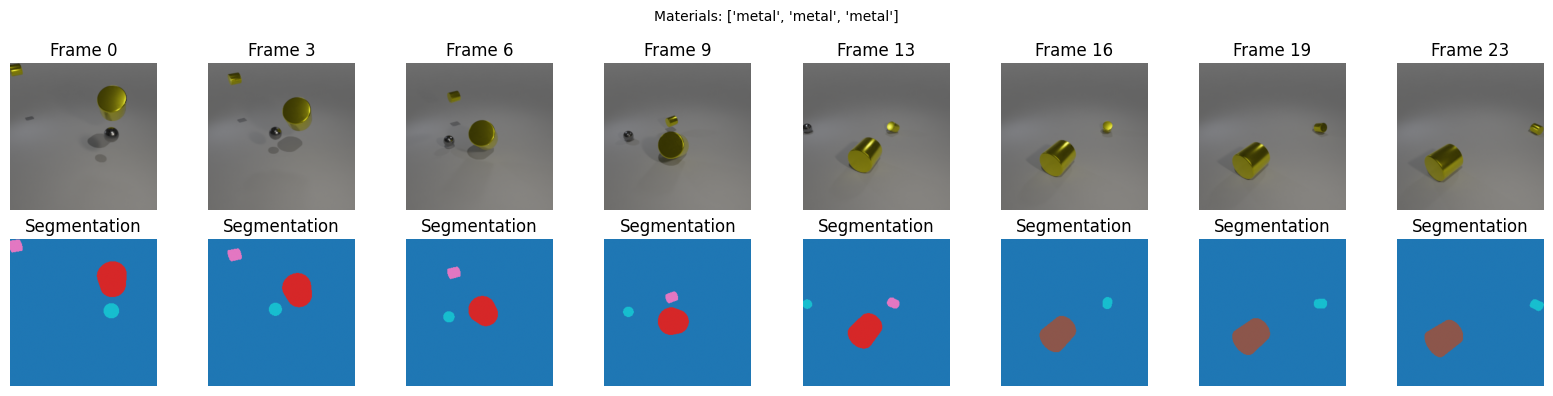

In [36]:
def visualize_pytorch_sample(sample, num_frames=8):
    """PyTorchサンプルの動画とセグメンテーションを可視化"""
    video = sample['video']  # (T, 3, H, W), normalized 0-1
    segmentation = sample['segmentation']  # (T, H, W)
    
    # フレーム数を制限
    t_total = video.shape[0]
    frame_indices = np.linspace(0, t_total-1, num_frames, dtype=int)
    
    fig, axes = plt.subplots(2, num_frames, figsize=(2*num_frames, 4))
    
    for i, t in enumerate(frame_indices):
        # RGB (CHW -> HWC, 0-1 -> 0-255)
        img = video[t].permute(1, 2, 0).numpy()
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Frame {t}")
        axes[0, i].axis('off')
        
        # Segmentation
        axes[1, i].imshow(segmentation[t].numpy(), cmap='tab10')
        axes[1, i].set_title("Segmentation")
        axes[1, i].axis('off')
    
    plt.suptitle(f"Materials: {sample['materials']}", fontsize=10)
    plt.tight_layout()
    plt.show()

# Metal-only サンプルを可視化
visualize_pytorch_sample(sample)

### 🎬 動画として再生

静止画だけでなく、実際に動画として再生することで光沢の動きをより明確に観察できる。
`matplotlib.animation` を使用してHTML5動画としてノートブック内に埋め込む。

**容量について**: 動画はBase64エンコードされてHTMLに埋め込まれるが、1動画あたり数MB程度。ノートブックファイル自体は保存時に出力をクリアすれば数十KB程度に収まる。

In [37]:
def create_pytorch_animation(sample, fps=8):
    """PyTorchサンプルをアニメーションとして表示"""
    video = sample['video']  # (T, 3, H, W)
    segmentation = sample['segmentation']  # (T, H, W)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # 初期フレーム (CHW -> HWC)
    im_rgb = axes[0].imshow(video[0].permute(1, 2, 0).numpy())
    axes[0].set_title("RGB")
    axes[0].axis('off')
    
    im_seg = axes[1].imshow(segmentation[0].numpy(), cmap='tab10', vmin=0, vmax=10)
    axes[1].set_title("Segmentation")
    axes[1].axis('off')
    
    title = fig.suptitle(f"Frame 0/{len(video)-1} | Materials: {sample['materials']}", fontsize=9)
    plt.tight_layout()
    
    def update(frame):
        im_rgb.set_array(video[frame].permute(1, 2, 0).numpy())
        im_seg.set_array(segmentation[frame].numpy())
        title.set_text(f"Frame {frame}/{len(video)-1} | Materials: {sample['materials']}")
        return [im_rgb, im_seg, title]
    
    anim = animation.FuncAnimation(
        fig, update, frames=len(video), 
        interval=1000//fps, blit=True
    )
    plt.close(fig)
    return anim

# 動画を作成・表示（JavaScript版、ffmpeg不要）
print("Metal-only sample animation:")
anim = create_pytorch_animation(sample, fps=8)
HTML(anim.to_jshtml())

Metal-only sample animation:


---

## 以下は TensorFlow 経由でデータをダウンロードする場合のコード

**注意**: すでに `.pt` ファイルとして保存済みであれば、以下のセルは実行不要である。
GCS からの再ダウンロードが必要な場合のみ実行すること。

---

## 3. 材質情報（Metal vs Rubber）の確認（TF版）

### 狙い
各物体の**材質ラベル**を読み取り、実験対象となる「金属」と「ゴム」の分布を把握する。

### 技術的な注意点
MOVi-Aのラベルは**整数インデックス**で格納されている：
- `material_label`: `0` = metal, `1` = rubber
- `shape_label`: `0` = cube, `1` = cylinder, `2` = sphere
- 他のデータセット（文字列で格納するもの）と異なるため、デコード処理が必要である

In [38]:
# === このセルはTensorFlowからダウンロードした場合のみ実行 ===
# すでに.ptファイルを使用している場合はスキップ

# TensorFlowデータをダウンロードする場合のみ以下を実行
USE_TENSORFLOW = False  # Trueに変更するとTensorFlowからダウンロード

if USE_TENSORFLOW:
    import tensorflow_datasets as tfds
    import tensorflow as tf
    
    print("Loading MOVi-A dataset from Google Cloud Storage...")
    ds = tfds.load(
        "movi_a/256x256",
        data_dir="gs://kubric-public/tfds",
        split="validation",
        shuffle_files=False
    )
    tf_sample = next(iter(ds))
    
    def decode_label(tensor, label_map=None):
        """ラベルをデコード（整数→文字列マッピング対応）"""
        val = tensor.numpy()
        if hasattr(val, 'decode'):
            return val.decode()
        elif isinstance(val, bytes):
            return val.decode()
        elif label_map is not None and isinstance(val, (int, np.integer)):
            return label_map[int(val)] if int(val) < len(label_map) else f"unknown({val})"
        else:
            return str(val)

    def show_instance_info(sample):
        """物体ごとのメタ情報を表示（TensorFlow形式用）"""
        instances = sample['instances']
        print("=== Instance Information ===")
        print(f"Available keys: {list(instances.keys())}")
        
        if 'shape_label' in instances:
            num_objects = len(instances['shape_label'])
            print(f"\nNumber of objects: {num_objects}")
            
            for i in range(num_objects):
                print(f"\nObject {i+1}:")
                if 'shape_label' in instances:
                    shape = decode_label(instances['shape_label'][i], SHAPE_LABELS)
                    print(f"  Shape: {shape}")
                if 'material_label' in instances:
                    material = decode_label(instances['material_label'][i], MATERIAL_LABELS)
                    print(f"  Material: {material} {'🔩' if material == 'metal' else '🏀'}")

    show_instance_info(tf_sample)
else:
    print("Skipped: Using pre-saved .pt files instead of TensorFlow download")

Skipped: Using pre-saved .pt files instead of TensorFlow download


### 💡 サンプルの物体構成

上記の出力例から、このサンプルには**3つの金属物体**（cylinder×2, sphere×1）が含まれていることが分かる。
- 🔩 = 金属（光沢あり）
- 🏀 = ゴム（つや消し）

この絵文字マーカーで材質を一目で識別できるようにしている。

## 4. 材質分布の統計調査

### 狙い
データセット全体で「金属のみ」「ゴムのみ」「混合」のサンプルがどれくらい存在するかを調査する。

### なぜ重要か
- **比較実験**を行うには、「金属のみのシーン」と「ゴムのみのシーン」を集める必要がある
- もし「ゴムのみ」が存在しなければ、実験設計を変更する必要がある（例: 混合シーン内でマスクを使って物体単位で比較）

In [40]:
# MOVi-Aのmaterial_labelは整数: 0=metal, 1=rubber
METAL_IDX = 0
RUBBER_IDX = 1

def has_metal_objects(sample):
    """サンプルに金属物体が含まれるかチェック"""
    materials = sample['instances']['material_label'].numpy()
    return METAL_IDX in materials

def has_rubber_only(sample):
    """サンプルがゴムのみかチェック"""
    materials = sample['instances']['material_label'].numpy()
    return METAL_IDX not in materials

# 統計を取る
metal_samples = []
rubber_samples = []
mixed_samples = []

print("Scanning dataset for material distribution...")
for i, sample in enumerate(ds.take(100)):  # 最初の100サンプルを確認
    materials = sample['instances']['material_label'].numpy()
    has_metal = METAL_IDX in materials
    has_rubber = RUBBER_IDX in materials
    
    if has_metal and has_rubber:
        mixed_samples.append(i)
    elif has_metal:
        metal_samples.append(i)
    elif has_rubber:
        rubber_samples.append(i)

print(f"\nOut of 100 samples:")
print(f"  - Metal only: {len(metal_samples)} samples")
print(f"  - Rubber only: {len(rubber_samples)} samples")
print(f"  - Mixed (metal + rubber): {len(mixed_samples)} samples")

Scanning dataset for material distribution...

Out of 100 samples:
  - Metal only: 6 samples
  - Rubber only: 0 samples
  - Mixed (metal + rubber): 94 samples


### 📊 結果の解釈

**発見（100サンプル調査）**:
- Metal only: **6 サンプル (6%)**
- Rubber only: **0 サンプル (0%)**  ← 純粋なゴムのみのシーンは存在しない
- Mixed: **94 サンプル (94%)**

**含意**:
1. MOVi-A は「ゴムのみ」シーンを生成しない設計である
2. 比較実験は **「金属のみ」 vs 「混合」** で行う必要がある
3. または、混合シーン内でセグメンテーションマスクを使って **物体単位** で金属/ゴムを比較する

## 5. Metal vs Rubber の比較可視化

### 狙い
金属物体とゴム物体の**見た目の違い**を視覚的に確認する。

### 着目点
1. **光沢（Specular Highlight）**: 金属表面には明るい「光の反射」が見える
2. **時間変化**: カメラが動くと光沢位置が変化する（金属のみ）
3. **色の均一性**: ゴムは全体的に均一な色、金属は光沢部分が白っぽい

### SAVi/DINOSAUR にとって難しい理由
- 静止画では「白い光沢」を別のスロットに割り当ててしまう可能性がある
- 時系列では「光沢は動くが物体は一体」という手がかりが得られる

In [ ]:
def find_sample_with_material(ds, target_idx, max_search=100):
    """指定した材質を持つサンプルを探す"""
    for i, sample in enumerate(ds.take(max_search)):
        materials = sample['instances']['material_label'].numpy()
        if target_idx in materials:
            return sample, [MATERIAL_LABELS[m] for m in materials]
    return None, None

def find_sample_only_material(ds, target_idx, max_search=100):
    """指定した材質のみを持つサンプルを探す"""
    other_idx = 1 - target_idx
    for i, sample in enumerate(ds.take(max_search)):
        materials = sample['instances']['material_label'].numpy()
        if target_idx in materials and other_idx not in materials:
            return sample, [MATERIAL_LABELS[m] for m in materials]
    return None, None

# 金属のみのサンプルを探す
metal_sample, metal_materials = find_sample_only_material(ds, METAL_IDX)
print(f"Metal-only sample materials: {metal_materials}")

# ゴムのみのサンプルを探す
rubber_sample, rubber_materials = find_sample_only_material(ds, RUBBER_IDX)
print(f"Rubber-only sample materials: {rubber_materials}")

Metal-only sample materials: ['metal', 'metal', 'metal']
Rubber-only sample materials: None


2026-01-31 22:39:01.266143: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Sample with rubber (mixed): ['metal', 'rubber', 'metal', 'rubber', 'rubber', 'rubber', 'rubber', 'rubber', 'metal']


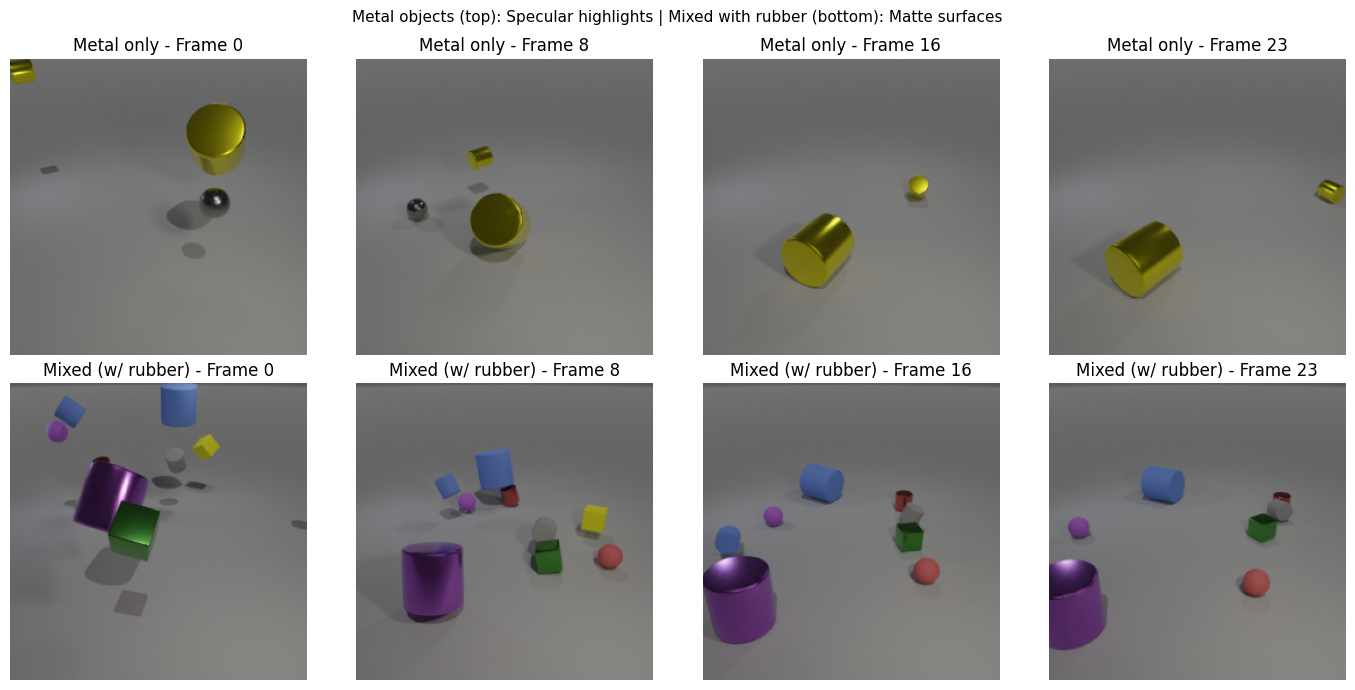

In [ ]:
# ゴム物体を含むサンプルも探す（純粋ゴムのみがないため）
rubber_mixed_sample, rubber_mixed_materials = find_sample_with_material(ds, RUBBER_IDX)
print(f"Sample with rubber (mixed): {rubber_mixed_materials}")

# 比較可視化
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

# Metal-only sample
if metal_sample is not None:
    video = metal_sample['video'].numpy()
    for i, t in enumerate([0, 8, 16, 23]):
        axes[0, i].imshow(video[t])
        axes[0, i].set_title(f"Metal only - Frame {t}")
        axes[0, i].axis('off')
else:
    print("No metal-only sample found")

# Mixed sample (with rubber)
if rubber_mixed_sample is not None:
    video = rubber_mixed_sample['video'].numpy()
    for i, t in enumerate([0, 8, 16, 23]):
        axes[1, i].imshow(video[t])
        axes[1, i].set_title(f"Mixed (w/ rubber) - Frame {t}")
        axes[1, i].axis('off')
else:
    print("No rubber sample found")

plt.suptitle("Metal objects (top): Specular highlights | Mixed with rubber (bottom): Matte surfaces", fontsize=11)
plt.tight_layout()
plt.show()

### 🔍 可視化結果の観察ポイント

**上段（Metal only）**:
- 黄色いシリンダーや灰色の球に**光沢（白い反射）**が見える
- フレームが進むにつれて光沢位置が移動する（カメラ回転のため）
- 表面が滑らかで光る（Phongシェーディングモデル）

**下段（Mixed with rubber）**:
- 紫の金属シリンダー: 光沢あり
- 青・ピンクのゴム物体: **つや消し（matte）** で均一な色
- 同じシーン内で材質の違いが明確である

**研究への示唆**:
- 「光沢の時間的変化パターン」は金属特有の特徴である
- SAVi（時系列Slot Attention）なら、この特徴を活かして正確な物体分離が可能と考えられる

## 6. PyTorch用にデータを変換して保存

### 狙い
TensorFlow形式のMOVi-AデータをPyTorchテンソルに変換し、後のSAVi-DINOSAUR学習で使用できるようにする。

### なぜ変換が必要か
- **TensorFlowは読み込みのみ**: MOVi-Aの公式配布がTFDS形式のため、読み込みにはtensorflow-datasetsが必要
- **学習はPyTorch**: SAVi-DINOSAURの実装はPyTorchベースであり、DataLoaderで読み込める形式に変換する
- **一度変換すれば再利用可能**: `.pt` ファイルとして保存すれば、以降TensorFlowは不要である

### データ変換仕様

| 元の形式 | 変換後 | 説明 |
|----------|--------|------|
| `(T, H, W, 3)` uint8 | `(T, 3, H, W)` float32 | CHW形式に変換、0-1正規化 |
| `(T, H, W, 1)` int32 | `(T, H, W)` int64 | チャンネル次元を削除 |
| 整数ラベル | 文字列リスト | 人間可読な形式に変換 |

### 保存戦略
- **Metal only**: 純粋な金属シーン（光沢実験のベースライン）
- **Mixed**: 金属+ゴム混合（同一シーン内での材質比較用）
- 各カテゴリ10サンプルずつ（合計20サンプル）で小規模実験を行う

In [ ]:
import torch
import os

def convert_to_pytorch(sample):
    """TensorFlowサンプルをPyTorchテンソルに変換"""
    video = torch.from_numpy(sample['video'].numpy())  # (T, H, W, 3)
    video = video.permute(0, 3, 1, 2).float() / 255.0  # (T, 3, H, W), normalized
    
    segmentation = torch.from_numpy(sample['segmentations'].numpy())  # (T, H, W, 1)
    segmentation = segmentation.squeeze(-1)  # (T, H, W)
    
    # メタデータ（整数インデックスを文字列に変換）
    materials = [MATERIAL_LABELS[m] for m in sample['instances']['material_label'].numpy()]
    shapes = [SHAPE_LABELS[s] for s in sample['instances']['shape_label'].numpy()]
    colors = [COLOR_LABELS[c] for c in sample['instances']['color_label'].numpy()]
    
    return {
        'video': video,
        'segmentation': segmentation,
        'materials': materials,
        'shapes': shapes,
        'colors': colors,
        'has_metal': 'metal' in materials
    }

# テスト
pytorch_sample = convert_to_pytorch(sample)
print(f"Video shape: {pytorch_sample['video'].shape}")
print(f"Segmentation shape: {pytorch_sample['segmentation'].shape}")
print(f"Materials: {pytorch_sample['materials']}")
print(f"Has metal: {pytorch_sample['has_metal']}")

Video shape: torch.Size([24, 3, 256, 256])
Segmentation shape: torch.Size([24, 256, 256])
Materials: ['metal', 'metal', 'metal', 'rubber', 'rubber', 'rubber', 'metal']
Has metal: True


In [ ]:
# 小規模なサブセットを保存（実験用）
def save_subset(ds, output_dir, num_samples=20):
    """データセットのサブセットをPyTorchフォーマットで保存"""
    os.makedirs(output_dir, exist_ok=True)
    
    metal_count = 0
    mixed_count = 0
    
    for i, sample in enumerate(ds.take(num_samples * 3)):  # 余裕を持って取得
        pytorch_sample = convert_to_pytorch(sample)
        
        # Metal only (no rubber)
        if 'rubber' not in pytorch_sample['materials'] and metal_count < num_samples // 2:
            torch.save(pytorch_sample, os.path.join(output_dir, f"metal_{metal_count:03d}.pt"))
            metal_count += 1
            print(f"Saved metal-only sample {metal_count}")
        # Mixed (has both metal and rubber)
        elif 'metal' in pytorch_sample['materials'] and 'rubber' in pytorch_sample['materials'] and mixed_count < num_samples // 2:
            torch.save(pytorch_sample, os.path.join(output_dir, f"mixed_{mixed_count:03d}.pt"))
            mixed_count += 1
            print(f"Saved mixed sample {mixed_count}")
        
        if metal_count + mixed_count >= num_samples:
            break
    
    print(f"\nSaved {metal_count} metal-only and {mixed_count} mixed samples to {output_dir}")

# 保存実行
save_subset(ds, "../data/movi_a_subset", num_samples=20)

Saved metal-only sample 1
Saved mixed sample 1
Saved mixed sample 2
Saved mixed sample 3
Saved mixed sample 4
Saved mixed sample 5
Saved mixed sample 6
Saved mixed sample 7
Saved mixed sample 8
Saved mixed sample 9
Saved mixed sample 10
Saved metal-only sample 2
Saved metal-only sample 3
Saved metal-only sample 4
Saved metal-only sample 5

Saved 5 metal-only and 10 mixed samples to ../data/movi_a_subset


## 7. 結論と次のステップ

### このノートブックで判明したこと

| 発見 | 含意 |
|------|------|
| MOVi-Aに「ゴムのみ」シーンは存在しない | 比較実験は「金属のみ」vs「混合」で行う |
| 金属物体には明確な光沢反射がある | 視覚的に「金属らしさ」を確認できた |
| 光沢位置はフレームごとに変化する | 時系列情報が鍵になりうる |
| セグメンテーションGTは高品質である | 評価指標の計算に使用可能 |

### 保存したデータ
```
data/movi_a_subset/
├── metal_000.pt ～ metal_004.pt  (5個: 金属のみのシーン)
└── mixed_000.pt ～ mixed_009.pt  (10個: 金属+ゴム混合)
```

### 次のステップ

1. **SAVi-DINOSAUR での学習**
   - `src/savi_dinosaur.py` を使用
   - 保存した `.pt` ファイルでDatasetを作成
   - 時系列Slot Attentionの有効性を検証

2. **材質別の Temporal Consistency 評価**
   - 金属物体のスロット割り当てが安定しているか
   - ゴム物体との違いを定量化

3. **仮説検証**
   > 「金属光沢は静止画単体では分離困難だが、動画なら物体として追跡できる」

4. **発展**: 有効であれば、MOVi-B/C でより複雑なシーンで検証する

### TensorFlow依存について
- このノートブックでは**データ読み込みのみ**にTensorFlowを使用
- 変換後の `.pt` ファイルを使えば、学習・評価は**PyTorchのみ**で完結する
- 今後の拡張として、TFRecordを直接読むPyTorchライブラリ（`tfrecord`パッケージ）への移行も検討可能